In [1]:
# Download the corresponding PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above, E.g., export TORCH=1.13.1+cu113
"""
%env TORCH=2.1.0+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool,global_max_pool
import random

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Load ENZYMES,MUTAG,PROTEINS dataset
random.seed(1)
dataset = TUDataset(root='data/TUDataset', name='MUTAG', use_node_attr=True)
dataset = dataset.shuffle()

# Train/test split (80/20)
split_idx = int(0.8 * len(dataset))
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


Processing...
Done!


In [5]:

import pdb
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
import random
from torch_geometric.utils import to_dense_adj


class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        adj = to_dense_adj(edge_index, max_num_nodes=x.size(0))[0]
        # Move torch.eye to the same device as adj
        adj_i = adj + torch.eye(adj.size(0), device=adj.device)

        aggregated_neighbors0 =  torch.matmul(adj_i, x)
        x = self.layer1(aggregated_neighbors0)
        x = F.relu(x)

        aggregated_neighbors1 = torch.matmul(adj_i, x)
        x = self.layer2(aggregated_neighbors1)
        x = F.relu(x)

        x = global_max_pool(x, batch)
        x = self.lin(x)
        return x

    def get_ebd(self, x, edge_index):
        adj = to_dense_adj(edge_index, max_num_nodes=x.size(0))[0]
        # Move torch.eye to the same device as adj
        adj_i = adj + torch.eye(adj.size(0), device=adj.device)

        aggregated_neighbors0 =  torch.matmul(adj_i, x)
        x = self.layer1(aggregated_neighbors0)
        x = F.relu(x)

        aggregated_neighbors1 = torch.matmul(adj_i, x)
        x = self.layer2(aggregated_neighbors1)
        x = F.relu(x)
        return x


In [6]:
# Instantiate model
model = GIN(input_dim=dataset.num_node_features,
            hidden_dim=32,
            output_dim=dataset.num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
# Training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

def reset_weights(m):
    if isinstance(m, (torch.nn.Linear, GCNConv)):
        m.reset_parameters()



In [12]:
# Train
model.apply(reset_weights)
num_epochs = 60
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if epoch % 20 == 0:
      print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00, Loss: 0.8580, Train Acc: 0.6600, Test Acc: 0.6842
Epoch 20, Loss: 0.5306, Train Acc: 0.6667, Test Acc: 0.7368
Epoch 40, Loss: 0.4551, Train Acc: 0.7800, Test Acc: 0.7368


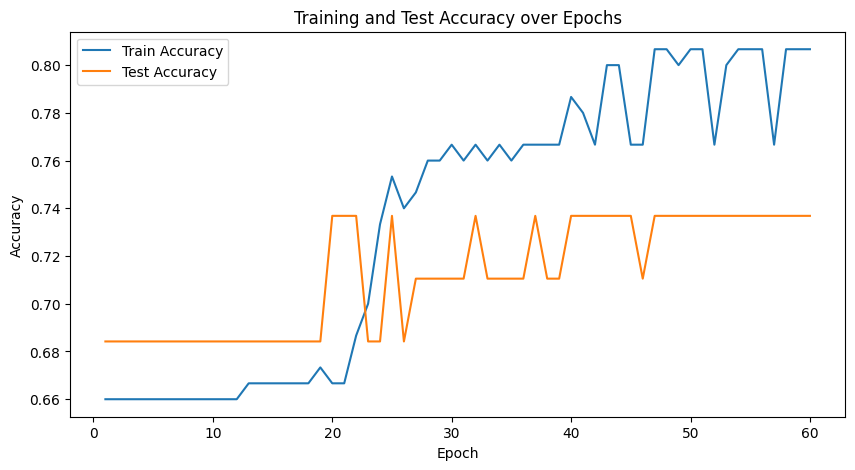

In [13]:
# Plot the training and test accuracy curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()

In [14]:
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import time
from time import sleep
from copy import deepcopy
from torch_geometric.utils import to_dense_adj
from Perturbe_Algs import Attacks

In [15]:
random_dataset = [deepcopy(data) for data in test_dataset]
pgdavg_dataset = [deepcopy(data) for data in test_dataset]
pgdwst_dataset = [deepcopy(data) for data in test_dataset]

rep_num = 5
list_acc_pgdavg = []
list_acc_pgdwst = []
list_acc_random = []

list_embed_pgdavg = []
list_embed_pgdwst = []
list_embed_random = []

for l in range(rep_num):
  embed_pgdavg = []
  embed_pgdwst = []
  embed_random = []
  for i in tqdm(range(len(test_dataset))):
    data = test_dataset[i].to(device)
    edge_index = data.edge_index
    dataA = to_dense_adj(edge_index)[0].clone()
    K = (data.x) @ (data.x).T
    if dataA.shape[0] == data.x.shape[0]:
      n = dataA.shape[0]
      num = int(n*n*0.05)
      attack_instance = Attacks(dataA, K, m=num, filter = 'adj').to(device)
      A_pgd_avg = attack_instance.Prob_PGD().clone().detach()
      A_pgd_wst = attack_instance.Wst_PGD().clone().detach()
      A_random = attack_instance.randomAttack().clone().detach()
    else:
      print('Miss matched data: no operation')
      A_pgd_avg = dataA.clone().detach()
      A_pgd_wst = dataA.clone().detach()
      A_random = dataA.clone().detach()

    random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
    pgdavg_edge_index = torch.tensor(A_pgd_avg).nonzero(as_tuple=False).t().contiguous()
    pgdwst_edge_index = torch.tensor(A_pgd_wst).nonzero(as_tuple=False).t().contiguous()

    random_dataset[i].edge_index = random_edge_index
    pgdavg_dataset[i].edge_index = pgdavg_edge_index
    pgdwst_dataset[i].edge_index = pgdwst_edge_index

    model.eval()
    with torch.no_grad():
      ebd_test = model.get_ebd(data.x, data.edge_index)
      ebd_pgd_avg = model.get_ebd(data.x, pgdavg_edge_index)
      ebd_pgd_wst = model.get_ebd(data.x, pgdwst_edge_index)
      ebd_random = model.get_ebd(data.x, random_edge_index)

      embed_pgdavg.append(torch.norm(ebd_test - ebd_pgd_avg, p = 'fro'))
      embed_pgdwst.append(torch.norm(ebd_test - ebd_pgd_wst, p = 'fro'))
      embed_random.append(torch.norm(ebd_test - ebd_random, p = 'fro'))


  pgdavg_test_loader = DataLoader(pgdavg_dataset, batch_size=len(pgdavg_dataset), shuffle=False)
  pgdwst_test_loader = DataLoader(pgdwst_dataset, batch_size=len(pgdwst_dataset), shuffle=False)
  random_test_loader = DataLoader(random_dataset, batch_size=len(random_dataset), shuffle=False)

  list_embed_pgdavg.append(sum(embed_pgdavg).item())
  list_embed_pgdwst.append(sum(embed_pgdwst).item())
  list_embed_random.append(sum(embed_random).item())

  print(f"-----Iteration {l:d}-----")
  print(f"Test Acc: {test_acc:.4f}")

  pgdavg_test_acc = test(pgdavg_test_loader)
  list_acc_pgdavg.append(pgdavg_test_acc)
  print(f"Prob_PGD Test Acc: {pgdavg_test_acc:.4f}")

  pgdwst_test_acc = test(pgdwst_test_loader)
  list_acc_pgdwst.append(pgdwst_test_acc)
  print(f"Wst_PGD Test Acc: {pgdwst_test_acc:.4f}")

  random_test_acc = test(random_test_loader)
  list_acc_random.append(random_test_acc)
  print(f"Random Test Acc: {random_test_acc:.4f}")



  0%|          | 0/38 [00:00<?, ?it/s]

<ipython-input-15-4db0a4c72061>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_edge_index = torch.tensor(A_random).nonzero(as_tuple=False).t().contiguous()
<ipython-input-15-4db0a4c72061>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pgdavg_edge_index = torch.tensor(A_pgd_avg).nonzero(as_tuple=False).t().contiguous()
<ipython-input-15-4db0a4c72061>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pgdwst_edge_index = torch.tensor(A_pgd_wst).nonzero(as_tuple=False).t().contiguous()


-----Iteration 0-----
Test Acc: 0.7368
Prob_PGD Test Acc: 0.8158
Wst_PGD Test Acc: 0.3421
Random Test Acc: 0.7632


  0%|          | 0/38 [00:00<?, ?it/s]

-----Iteration 1-----
Test Acc: 0.7368
Prob_PGD Test Acc: 0.8158
Wst_PGD Test Acc: 0.3421
Random Test Acc: 0.8158


  0%|          | 0/38 [00:00<?, ?it/s]

-----Iteration 2-----
Test Acc: 0.7368
Prob_PGD Test Acc: 0.8158
Wst_PGD Test Acc: 0.3421
Random Test Acc: 0.7105


  0%|          | 0/38 [00:00<?, ?it/s]

-----Iteration 3-----
Test Acc: 0.7368
Prob_PGD Test Acc: 0.8158
Wst_PGD Test Acc: 0.3421
Random Test Acc: 0.8158


  0%|          | 0/38 [00:00<?, ?it/s]

-----Iteration 4-----
Test Acc: 0.7368
Prob_PGD Test Acc: 0.8158
Wst_PGD Test Acc: 0.3421
Random Test Acc: 0.7368


In [16]:
print(f"Test: {test_acc*100:.2f}")
print(f"Mean of random: {np.mean(list_acc_random):.2f}, std:{np.std(list_acc_random):.2f}")
print(f"Mean of Wst_PGD: {np.mean(list_acc_pgdwst):.2f}, std: {np.std(list_acc_pgdwst):.2f}")
print(f"Mean of Prob_PGD:{np.mean(list_acc_pgdavg):.2f}, std: {np.std(list_acc_pgdavg):.2f}")


Test: 73.68
Mean of random: 0.77, std:0.04
Mean of Wst_PGD: 0.34, std: 0.00
Mean of Prob_PGD:0.82, std: 0.00


In [17]:

print(f"Mean of random embedding norm: {np.mean(list_embed_random):.0f}, std:{np.std(list_embed_random):.0f}")
print(f"Mean of Wst_PGD embedding norm: {np.mean(list_embed_pgdwst):.0f}, std: {np.std(list_embed_pgdwst):.0f}")
print(f"Mean of Prob_PGD embedding norm:{np.mean(list_embed_pgdavg):.0f}, std: {np.std(list_embed_pgdavg):.0f}")

Mean of random embedding norm: 1154, std:18
Mean of Wst_PGD embedding norm: 2235, std: 0
Mean of Prob_PGD embedding norm:3262, std: 0


<ipython-input-18-de5d6de50e7c>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


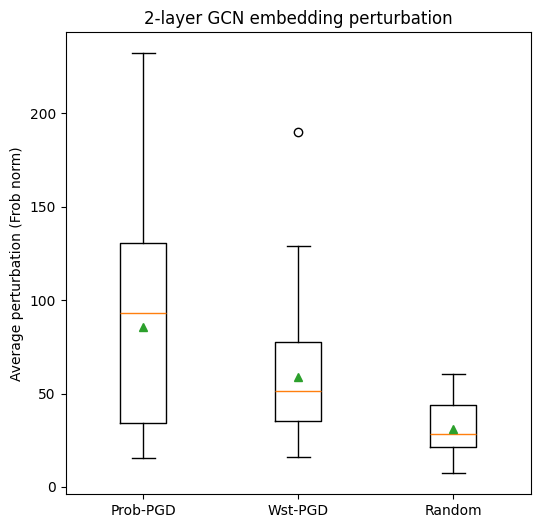

In [18]:
plt.figure(figsize=(6, 6))
plt.boxplot([
    [e.cpu() for e in embed_pgdavg],
    [e.cpu() for e in embed_pgdwst],
    [e.cpu() for e in embed_random]
], labels=['Prob-PGD', 'Wst-PGD', 'Random'],showmeans = True)
plt.ylabel('Average perturbation (Frob norm)')
plt.title('2-layer GCN embedding perturbation')
plt.show()